C:\Users\dario\AppData\Local\Temp\ipykernel_34032\3531529801.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(file)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


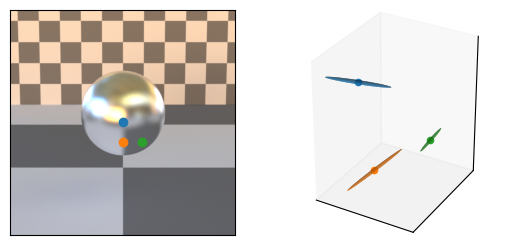

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import imageio
imageio.plugins.freeimage.download()

def load_image(file):
    return imageio.imread(file)

def load_aniso(file):
    anisotropies = np.reshape(np.fromfile(file, dtype=np.float32), (-1,3,3))

    pixel_pos = np.reshape(np.fromfile(file.replace("anisotropies", "anisotropies-pixelpos"), dtype=np.uint32), (-1,2))
    intersect_pos = np.reshape(np.fromfile(file.replace("anisotropies", "anisotropies-intersects"), dtype=np.float32), (-1,3))

    anisos = {}
    intersects = {}
    for p,a,ip in zip(pixel_pos, anisotropies, intersect_pos):
        anisos[(p[0], p[1])] = a
        intersects[(p[0], p[1])] = ip

    return anisos, intersects, intersect_pos

img = load_image("\\\\dartfs-hpc\\rc\\lab\\J\\JaroszLab\\dseyb\\stimp\\gp-medium-sphere\\gp-medium-sphere-softlight-rough-rq.exr")
anisos, intersects, intersects_values = load_aniso("testing/intersections/gp-medium-sphere-softlight-rough/anisotropies.bin")

fig = plt.figure()
im_ax = fig.add_subplot(121)
im_ax.imshow(img**(1/2.2))
im_ax.set_yticks([])
im_ax.set_xticks([])

ax = fig.add_subplot(122, projection="3d")
ax.view_init(vertical_axis="y")
ax.invert_zaxis()
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

coord = (256, 256)
def draw_coord(coord, im_ax, ax):
    im_ax.scatter(*coord)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    sphere = np.stack((x, y, z), axis=-1)[..., None]

    e, v = np.linalg.eig(anisos[coord])
    s = v @ np.diag(np.sqrt(e)) @ v.T
    ellipsoid = (s @ sphere).squeeze(-1) * 0.01 + intersects[coord]

    ax.plot_surface(*ellipsoid.transpose(2, 0, 1), rstride=4, cstride=4, alpha=0.75)
    ax.scatter3D(*intersects[coord])

draw_coord((256, 256), im_ax, ax)
draw_coord((256, 300), im_ax, ax)
draw_coord((300, 300), im_ax, ax)

#ax.scatter3D(*intersects_values.transpose(1,0), alpha=0.1, s=0.1)
ax.set_aspect("equal")

plt.show()